Este cuadernillo contiene todo el código empleado para realizar la parte de nuestro TFM relativa al análisis del dataset Youtube Video Trending Dataset. Incluye las siguientes secciones:

- Instalación de subprogramas y librerías
- Preprocesamiento de los datos
- Obtención y análisis de características de los datos

## Instalación de subprogramas y librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import isodate #para manejar formato de duración ISO 8601
import re #para manejar expresiones regulares
from textblob import TextBlob

## Preprocesamiento de datos

In [2]:
# PASO 1: LECTURA DEL ARCHIVO
df = pd.read_csv("videos_virales_final_cleaned.csv", low_memory=False)

In [3]:
# El primer paso del preprocesado es eliminar columnas que consideramos innecesarias para el estudio. Estas son: 
# channel_id,video_dimension, channel_have_hidden_subscribers, channel_localized_title, channel_localized_description
elim_columns = ['channel_id','video_dimension', 'channel_have_hidden_subscribers', 'channel_localized_title', 'channel_localized_description']
df = df.drop(columns=elim_columns)

In [4]:
#Debemos eliminar las filas con video_id nulo, ya que esa será la variable principal para la identificación de los vídeos.
#Según los metadatos ofrecidos por Kaggle, hay 13 instancias de ese tipo.
df = df.dropna(subset=['video_id'])

In [5]:
#A continuación trataremos el resto de valores NaN.
#Para columnas alfanuméricas (string), cambiar por ""
#Para columnas numéricas,
alfanumeric_values = {"video_trending_country": "", "video_description": "", "video_category_id": "", "video_tags": ""}

#de momento no

In [6]:
#Guardamos el dataset resultante en un csv para evitar repetir el proceso
df.to_csv('ytvg_clean.csv', index=False)

In [7]:
#Creamos un dataset auxiliar que contenga solamente una instancia de cada vídeo. Es decir, deberá tener unas 180.000 instancias.
df_unique = df.drop_duplicates(subset=['video_id'], keep='first')
df_unique.to_csv('ytvg_unique.csv', index=False)

## Obtención y análisis de características

In [8]:
df = pd.read_csv("ytvg_unique.csv")

In [9]:
df.columns

Index(['video_id', 'video_published_at', 'video_trending__date',
       'video_trending_country', 'video_title', 'video_description',
       'video_default_thumbnail', 'video_category_id', 'video_tags',
       'video_duration', 'video_definition', 'video_licensed_content',
       'video_view_count', 'video_like_count', 'video_comment_count',
       'channel_title', 'channel_description', 'channel_custom_url',
       'channel_published_at', 'channel_country', 'channel_view_count',
       'channel_subscriber_count', 'channel_video_count', 'thumbnail_url_hq',
       'thumbnail_faces_count', 'title_length', 'title_word_count',
       'title_has_exclamation', 'title_has_question', 'title_sentiment',
       'title_has_keywords', 'title_uppercase_ratio', 'description_length',
       'description_sentiment', 'has_external_links', 'tag_count',
       'video_duration_sec', 'published_at', 'hour_of_day', 'day_of_week',
       'is_weekend', 'is_peak_hour', 'thumbnail_text_count',
       'thumbnail

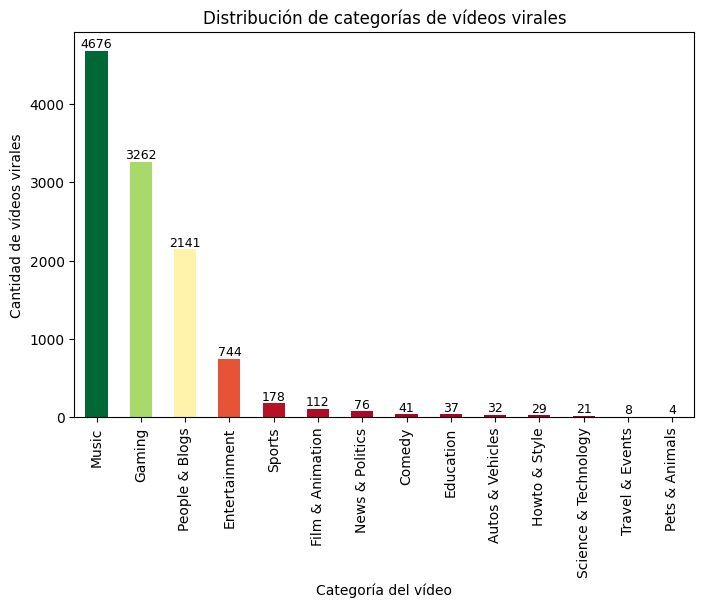

In [10]:
#Análisis de categorías
categories = df['video_category_id'].value_counts()
plt.figure(figsize=(8,5))
bars = categories.plot(kind='bar', color=plt.cm.RdYlGn(categories/categories.max()))

plt.title(f"Distribución de categorías de vídeos virales")
plt.xlabel("Categoría del vídeo")
plt.ylabel("Cantidad de vídeos virales")
plt.xticks(rotation=90)

for i, value in enumerate(categories):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)

plt.show()

In [11]:
#Análisis de duración. Formato de la duración: ISO 8601
#Transformar todas las duraciones a segundos.
df["video_duration_segs"] = df["video_duration"].apply(lambda x: int(isodate.parse_duration(x).total_seconds()))
df["video_duration_segs"].describe()

count    11371.000000
mean      2746.164453
std       6241.279159
min          9.000000
25%        192.000000
50%        350.000000
75%       1520.000000
max      73561.000000
Name: video_duration_segs, dtype: float64

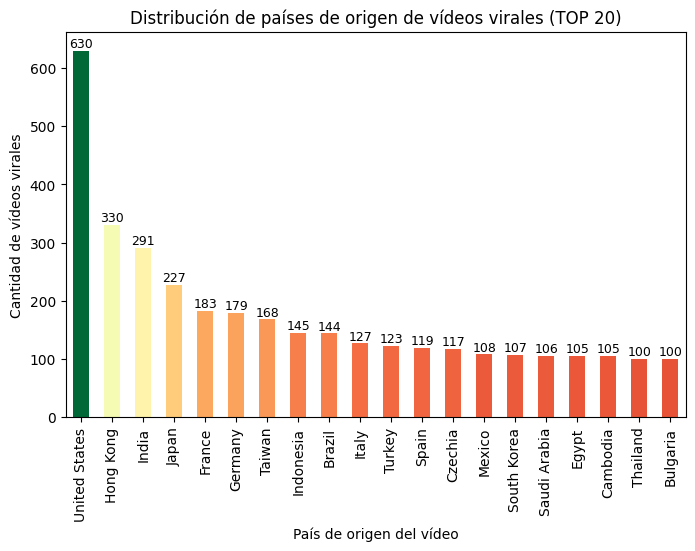

In [12]:
#País de origen de los vídeos
categories = df['channel_country'].value_counts()
categories = categories[0:20]
plt.figure(figsize=(8,5))
bars = categories.plot(kind='bar', color=plt.cm.RdYlGn(categories/categories.max()))

plt.title(f"Distribución de países de origen de vídeos virales (TOP 20)")
plt.xlabel("País de origen del vídeo")
plt.ylabel("Cantidad de vídeos virales")
plt.xticks(rotation=90)

for i, value in enumerate(categories):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)

plt.show()

In [13]:
#Análisis de título (idioma, tamaño, emojis)

In [14]:
#Ratio visitas-suscriptores

## Preprocesamiento títulos - análisis de sentimientos

In [15]:
#funcion para extraer algunas características del título
def extract_features(df):
    df['title_length'] = df['video_title'].apply(lambda x: len(str(x)))
    df['title_word_count'] = df['video_title'].apply(lambda x: len(str(x).split()))
    df['title_has_exclamation'] = df['video_title'].apply(lambda x: '!' in str(x))
    df['title_has_question'] = df['video_title'].apply(lambda x: '?' in str(x))
    df['title_sentiment'] = df['video_title'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['description_length'] = df['video_description'].apply(lambda x: len(str(x)))
    df['description_sentiment'] = df['video_description'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df

In [16]:
df_preproc = df
df_preproc = extract_features(df_preproc)

# 2. Eliminar columnas irrelevantes y peligrosas para evitar fuga de datos

# Explicación:
# Eliminamos identificadores, URLs, descripciones redundantes, el target y cualquier variable derivada del target.
# Así evitamos fuga de datos y aseguramos que el modelo solo use información disponible antes de saber si un vídeo es viral.
# No eliminamos variables originales del vídeo/canal ni features extraídas del texto.

# Preprocesado para predicción antes de publicar
# Elimina TODAS las variables de interacción y métricas post-publicación
cols_to_drop = [
    'video_id', 'channel_id', 'video_default_thumbnail', 'thumbnail_url_hq',
    'channel_title', 'channel_description', 'channel_custom_url',
    'channel_localized_title', 'channel_localized_description', 'published_at',
    'is_viral', 'viral_score',  # targets
    'video_view_count', 'video_like_count', 'video_comment_count',
    'views_per_second', 'likes_per_view', 'likes_per_sub', 'views_per_sub',
    'channel_view_count', 'channel_subscriber_count', 'channel_video_count'
]
cols_to_drop += ['video_tags', 'channel_country']
df_preproc_clf = df.copy()
df_preproc_clf = extract_features(df_preproc_clf)
df_preproc_clf.drop(columns=[col for col in cols_to_drop if col in df_preproc_clf.columns], inplace=True)

# Imputar nulos y codificar categóricas
num_cols = df_preproc_clf.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df_preproc_clf.select_dtypes(include='object').columns
for col in cat_cols:
    df_preproc_clf[col] = df_preproc_clf[col].fillna('Unknown')
    from sklearn.preprocessing import LabelEncoder
    df_preproc_clf[col] = LabelEncoder().fit_transform(df_preproc_clf[col])
for col in num_cols:
    df_preproc_clf[col] = df_preproc_clf[col].fillna(df_preproc_clf[col].median())
cat_cols = df_preproc_clf.select_dtypes(include='object').columns
for col in cat_cols:
    df_preproc_clf[col] = df_preproc_clf[col].fillna('Unknown')

# Estandarizar numéricas
from sklearn.preprocessing import StandardScaler
num_cols = df_preproc_clf.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
df_preproc_clf[num_cols] = scaler.fit_transform(df_preproc_clf[num_cols])

In [17]:
df_preproc

,video_id,video_published_at,video_trending__date,video_trending_country,video_title,video_description,video_default_thumbnail,video_category_id,video_tags,video_duration,...,is_peak_hour,thumbnail_text_count,thumbnail_colorfulness,is_viral,viral_score,views_per_second,likes_per_view,likes_per_sub,views_per_sub,video_duration_segs
0,2ttVjSrLEZE,2024-10-02T15:00:27Z,2024.10.12,United Arab Emirates,Ayed - Ma Hada Bali | Official Music Video 202...,للإشتراك في القناة | https://rb.gy/7wjde8\nللا...,https://i.ytimg.com/vi/2ttVjSrLEZE/default.jpg,Music,"Ayed,Ayedh Yousef,Ma Hada Bali,أجدد الأغاني ال...",PT5M1S,...,True,0.0,11.933030,1,1137.770604,5407.291391,0.019319,2.175574,112.613061,301
1,cyCfVb0_FZg,2024-09-26T16:00:22Z,2024.10.12,Bulgaria,SHUNAKA - Mr.DaiMiPariteSi [OFFICIAL 4K VIDEO]...,Subscribe to Shunaka: https://bit.ly/3Mt8U6h\n...,https://i.ytimg.com/vi/cyCfVb0_FZg/default.jpg,Music,"shunaka,dsd,dim4ou,vrgo,virgo,trf,boro,purvi,p...",PT2M40S,...,True,0.0,66.092611,1,138.800536,669.881988,0.032637,0.314258,9.628694,160
2,O2XDDmyuycw,2024-09-27T07:00:06Z,2024.10.12,Bulgaria,Robi - Тихо (Official Video),"""Тихо, тихо, тихо... оставам с тебе""\n\nПърва ...",https://i.ytimg.com/vi/O2XDDmyuycw/default.jpg,Music,"роби,robi,tiho,tiho tiho,molec,молец,тихо,тихо...",PT2M53S,...,False,0.0,22.409323,1,161.039149,787.114943,0.040640,0.292932,7.207936,173
3,IoHXh4oGZM8,2024-09-22T08:08:44Z,2024.10.12,Bosnia and Herzegovina,"September 22, 2024",NaN,https://i.ytimg.com/vi/IoHXh4oGZM8/default.jpg,Entertainment,NaN,PT39S,...,False,0.0,25.591613,1,1220.609273,6058.800000,0.016517,0.292168,17.688636,39
4,nPBCrqxz30w,2024-09-17T16:00:45Z,2024.10.12,Bosnia and Herzegovina,Ja sa 32 i 102 godine😂,Dobro došli u život jedne prosečne balkanske p...,https://i.ytimg.com/vi/nPBCrqxz30w/default.jpg,People & Blogs,NaN,PT13S,...,True,0.0,18.225224,1,3159.208888,15765.357143,0.022758,0.279040,12.261263,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11366,QU_BbKjhqvU,2025-08-13T10:45:15Z,2025.08.13,Cambodia,ជួបគ្នាជាថ្មី? អត្ថប្រយោជន៍សត្វ Grow a garden 🪴,Hello everyone welcome to my channel I’m back ...,https://i.ytimg.com/vi/QU_BbKjhqvU/default.jpg,Gaming,NaN,PT7M27S,...,False,0.0,63.154100,0,1.035167,3.756696,0.144893,0.069694,0.480720,447
11367,uEL7YaEmIfI,2025-08-13T07:02:26Z,2025.08.13,Cambodia,🔴 LIVE | GTA5 ជួយដឹកជញ្ជូនអីវាន់ផ្ទះគេ ជួយមើលល...,PayWay Link : https://link.payway.com.kh/ABAPA...,https://i.ytimg.com/vi/uEL7YaEmIfI/default.jpg,Gaming,NaN,PT3H20M42S,...,False,0.0,40.258105,0,0.457851,0.225608,0.048197,0.038405,0.796541,12042
11368,uu0lAVK7S8k,2025-08-13T13:08:33Z,2025.08.13,Cambodia,KOLYOK មកហើយមកហើយ,បើស្រឡាញ់ចូលចិត្ត សូមចុច Subscribe និង like vi...,https://i.ytimg.com/vi/uu0lAVK7S8k/default_liv...,Gaming,"streamer live,game,minecraft,kolyok gaming,VTB...",PT1H52M41S,...,False,0.0,45.453721,0,0.174238,0.259539,0.100228,0.018505,0.184523,6761
11369,-esUfP27zzA,2025-08-13T11:01:56Z,2025.08.13,Cambodia,Welcome To My Live Guy i'm back !!!!!,----------------------------------------------...,https://i.ytimg.com/vi/-esUfP27zzA/default_liv...,People & Blogs,NaN,PT1H57M12S,...,False,0.0,45.604300,0,0.223584,0.445614,0.055502,0.013082,0.235621,7032


## Predicción de viralidad antes de publicar el vídeo

En este enfoque, el modelo solo utilizará información disponible antes de la publicación (título, descripción, categoría, duración, horario, etc.) para predecir si un vídeo será viral. Se eliminan todas las variables de interacción y métricas que solo se conocen tras la publicación.

In [32]:
# Definir X e y para regresión (viral_score)

# Eliminar filas con NaN en viral_score para evitar errores en el entrenamiento
df = df[~df['viral_score'].isna()]
y_reg = df['viral_score']
X_reg = df_preproc_clf.loc[df.index].copy()

from sklearn.model_selection import train_test_split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

print('Shape X_train:', X_train_reg.shape)
print('Shape y_train:', y_train_reg.shape)

Shape X_train: (9021, 30)
Shape y_train: (9021,)


In [33]:
# Modelos de regresión y evaluación
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

models_reg = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(random_state=42, n_jobs=-1),
    'MLPRegressor': MLPRegressor(random_state=42, max_iter=3000)
}

for name, model in models_reg.items():
    model.fit(X_train_reg, y_train_reg)
    y_pred = model.predict(X_test_reg)
    mae = mean_absolute_error(y_test_reg, y_pred)
    rmse = root_mean_squared_error(y_test_reg, y_pred)
    r2 = r2_score(y_test_reg, y_pred)
    print(f'{name} - MAE: {mae:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}')

LinearRegression - MAE: 2030.508, RMSE: 4911.898, R2: -0.150
RandomForest - MAE: 1122.201, RMSE: 6705.693, R2: -1.143
RandomForest - MAE: 1122.201, RMSE: 6705.693, R2: -1.143
XGBoost - MAE: 803.460, RMSE: 4610.238, R2: -0.013
XGBoost - MAE: 803.460, RMSE: 4610.238, R2: -0.013
MLPRegressor - MAE: 2317.579, RMSE: 6102.156, R2: -0.775
MLPRegressor - MAE: 2317.579, RMSE: 6102.156, R2: -0.775


c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


### Optimización y validación de modelos de regresión
En esta sección se implementan:
- Búsqueda de hiperparámetros con GridSearchCV/RandomizedSearchCV.
- Validación cruzada con métricas de regresión (RMSE).
- Análisis de importancia de variables.

In [34]:
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
# Optimización de hiperparámetros para RandomForest (regresión)
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_search = RandomizedSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1),
                              param_distributions=param_dist_rf, n_iter=10, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1, random_state=42)
rf_search.fit(X_train_reg, y_train_reg)
print('Mejores hiperparámetros RandomForest:', rf_search.best_params_)

Mejores hiperparámetros RandomForest: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}


RandomForest optimizado - MAE: 1222.521, RMSE: 7308.812, R2: -1.546


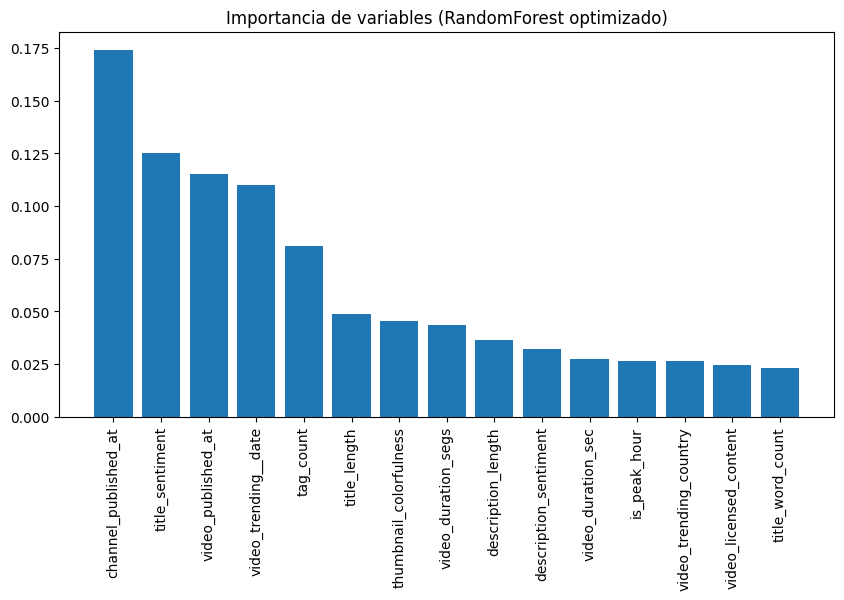

,feature,importance
9,channel_published_at,0.174081
15,title_sentiment,0.124935
0,video_published_at,0.115193
1,video_trending__date,0.110057
21,tag_count,0.081049
11,title_length,0.048602
28,thumbnail_colorfulness,0.045269
29,video_duration_segs,0.043234
18,description_length,0.036516
19,description_sentiment,0.031833


In [39]:
# Usar el mejor modelo encontrado por RandomizedSearchCV para predecir y evaluar
best_rf = rf_search.best_estimator_
y_pred_best = best_rf.predict(X_test_reg)
mae_best = mean_absolute_error(y_test_reg, y_pred_best)
rmse_best = root_mean_squared_error(y_test_reg, y_pred_best)
r2_best = r2_score(y_test_reg, y_pred_best)
print(f"RandomForest optimizado - MAE: {mae_best:.3f}, RMSE: {rmse_best:.3f}, R2: {r2_best:.3f}")

# Importancia de variables con el mejor modelo
importances_best = best_rf.feature_importances_
features_best = X_train_reg.columns
imp_df_best = pd.DataFrame({'feature': features_best, 'importance': importances_best}).sort_values('importance', ascending=False)
plt.figure(figsize=(10,5))
plt.bar(imp_df_best['feature'][:15], imp_df_best['importance'][:15])
plt.xticks(rotation=90)
plt.title('Importancia de variables (RandomForest optimizado)')
plt.show()
display(imp_df_best.head(15))

### Validación cruzada y curva de aprendizaje (regresión)
A continuación se implementan mejoras para validar la robustez del modelo:
- Validación cruzada (cross-validation) para obtener métricas más robustas (RMSE).
- Curva de aprendizaje para detectar overfitting/underfitting.

In [40]:
# Validación cruzada para RandomForest
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
scores = cross_val_score(rf, X_reg, y_reg, cv=5, scoring='neg_root_mean_squared_error')
print(f'RandomForest RMSE CV: {-scores.mean():.3f} ± {scores.std():.3f}')

RandomForest RMSE CV: 23943.103 ± 23138.115


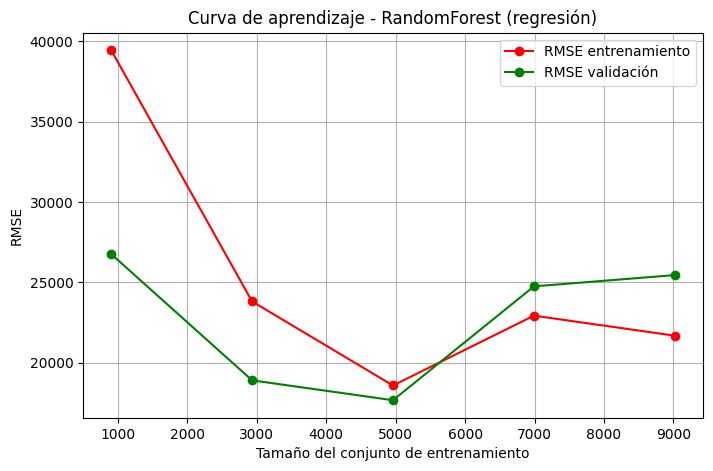

In [36]:
from sklearn.model_selection import learning_curve
import numpy as np

# Curva de aprendizaje para RandomForest (regresión)
# Si rf_search no está definido, entrenar un RandomForestRegressor básico para la curva de aprendizaje
try:
    estimator = rf_search.best_estimator_
except NameError:
    from sklearn.ensemble import RandomForestRegressor
    estimator = RandomForestRegressor(random_state=42, n_jobs=-1)
    estimator.fit(X_train_reg, y_train_reg)

train_sizes, train_scores, test_scores = learning_curve(
    estimator, X_reg, y_reg, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='RMSE entrenamiento')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='RMSE validación')
plt.title('Curva de aprendizaje - RandomForest (regresión)')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.grid()
plt.show()

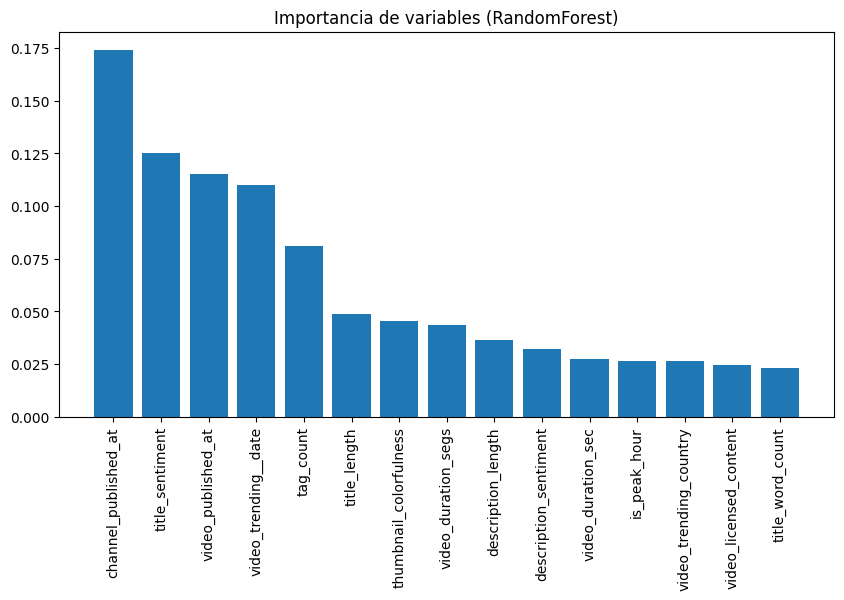

,feature,importance
9,channel_published_at,0.174081
15,title_sentiment,0.124935
0,video_published_at,0.115193
1,video_trending__date,0.110057
21,tag_count,0.081049
11,title_length,0.048602
28,thumbnail_colorfulness,0.045269
29,video_duration_segs,0.043234
18,description_length,0.036516
19,description_sentiment,0.031833


In [37]:
# Importancia de variables para RandomForest (regresión)
import matplotlib.pyplot as plt
import pandas as pd

# Usar el mejor modelo disponible: si existe rf_search, usarlo; si no, entrenar un RandomForestRegressor básico
try:
    model = rf_search.best_estimator_
except NameError:
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(random_state=42, n_jobs=-1)
    model.fit(X_train_reg, y_train_reg)

importances = model.feature_importances_
features = X_train_reg.columns
imp_df = pd.DataFrame({'feature': features, 'importance': importances}).sort_values('importance', ascending=False)
plt.figure(figsize=(10,5))
plt.bar(imp_df['feature'][:15], imp_df['importance'][:15])
plt.xticks(rotation=90)
plt.title('Importancia de variables (RandomForest)')
plt.show()
display(imp_df.head(15))